# Gesture Recognition
In this group project, we'll create a 3D Conv model that can accurately predict the five gestures. To begin, please import the following libraries. After finishing the code, you may download the notebook to submit it.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

To prevent significantly different outcomes, we set the random seed.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [9]:
#Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


You read the folder names for training and validation in this block. The 'batch_size' is also specified here. Keep in mind that you should choose the batch size such that you can utilize the GPU to its best potential. As soon as the machine raises an error, you keep raising the batch size.

**data path: /content/drive/MyDrive/Project_data**

In [4]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/Project_data/val.csv').readlines())
batch_size = 39

In [5]:
def image_specifications(nb_frames, x, y):
    return [np.round(np.linspace(0, 29, nb_frames)).astype('int'), x, y]


img_specs = image_specifications(20, 100, 100)

## Generator
This is arguably the most significant section of the code. The generator has been given its general structure. You will preprocess the photographs in the generator as well as produce a batch of video frames because the images are of two distinct dimensions. 'img_idx', 'y', 'z', and normalization must be experimented with to get great accuracy.

In [6]:
def get_batch_labels_and_data(source_path, t, batch, batch_size, img_specs):
    x, y, z = len(img_specs[0]), img_specs[1], img_specs[2]
    img_idx = img_specs[0]  # Make a list of the image reference you wish to utilize for each video.
    batch_data = np.zeros((batch_size, x, y, z, 3))  # The number of images you utilize for each video is x, the final size of the input images is (y,z), and there are three RGB channels.
    batch_labels = np.zeros((batch_size, 5))  # The one popular output representation is batch_labels.
    
    for folder in range(batch_size):  # iterating over the batch_size
        imgs = os.listdir('{0}/{1}'.format(source_path, t[folder + (batch * batch_size)].split(';')[0]))  # reading all the images in the folder
        
        for idx, item in enumerate(img_idx):  # Iterating over the frames/images of a folder to read them in
            image = imread('{0}/{1}/{2}'.format(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])).astype(np.float32)
            
            #Resize and crop the images. Keep in mind that the images are of two distinct shapes. 
            #and if a batch's inputs are of different shapes, conv3D will give an error.
            
            if image.shape[0] != image.shape[1]:
                image = image[:120, 20:140]
            image = resize(image, (y, z))
            
            batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255.0  # normalize and include the image
            batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255.0  # normalize and include the image
            batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255.0  # normalize and include the image
        
        batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
    
    return batch_data, batch_labels


def generator(source_path, folder_list, batch_size, img_specs=img_specs):
    print(f"Source Path: {source_path}; Batch Size: {batch_size}")
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list) / batch_size)
        for batch in range(num_batches):  # we are iterating over the number of batches
            yield get_batch_labels_and_data(source_path, t, batch, batch_size, img_specs)  # You give the batch_data and batch_labels, but keep in mind what yield actually accomplishes.
        
        # build the program to handle the data points that are still available after full batches.
        if len(folder_list) % batch_size != 0:
            batch_size = len(folder_list) % batch_size
            yield get_batch_labels_and_data(source_path, t, batch, batch_size, img_specs)  # You give the batch_data and batch_labels, but keep in mind what yield actually accomplishes.

Please take note that a video is shown as the following in the generator: (number of images, height, width, number of channels). Consider this while developing the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print(f"# training sequences: {num_train_sequences}")
num_val_sequences = len(val_doc)
print(f"# validation sequences: {num_val_sequences}")
num_epochs = 20 # choose the number of epochs
print(f"# epcohs: {num_epochs}")

# training sequences: 663
# validation sequences: 100
# epcohs: 20


## Model
Here, you create the model with several Keras functionalities. For a 3D convolution model, keep in mind to use "Conv3D" and "MaxPooling3D," not "Conv2D" and "Maxpooling2D." When creating a Conv2D + RNN model, you should use "TimeDistributed." Also keep in mind that the softmax is the final layer. Create the network so that the model can provide acceptable accuracy with the fewest amount of parameters possible, fitting into the webcam's memory.

In [8]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling3D
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling3D, MaxPooling2D
from tensorflow.keras.layers import TimeDistributed

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras import optimizers

In [ ]:
input_shape = (len(img_specs[0]), img_specs[1], img_specs[2], 3)

### Model - 1:

In [ ]:
# Describe your model here.

# model 1 -- base model

#model = Sequential()

#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))

#model.add(Conv3D(63, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=2))

#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(5, activation='softmax'))

Number of Epochs:- 20 <br />
Train accuracy:- 0.21 and Validation accuracy:- 0.42 <br />
The model is unable to learn and developing by adding more layers.

### Model - 2

In [ ]:
# model 2 -- expanding the number of layers

# model = Sequential()

# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(32, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(64, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(128, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(63, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))

Number of Epochs:- 20<br />
Train accuracy:- 0.60 and Validation accuracy: 0.76 <br />
Some of the parameters are reduced as a result of the train accuracy and validation accuracy being below average.

### Model - 3

In [ ]:
# model 3 -- lowering the number of the parameters

# model = Sequential()

# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
# model.add(Flatten())
# model.add(Dense(64,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))

Number of Epcohs: 20 <br />
Train accuracuy: 0.96 and Validation accuracy: 0.82 <br />
The model appears to be overfitting, further reducing the number of parameters.

### Model - 4

In [ ]:
# model 4 -- lowering still more trainable variables

# model = Sequential()

# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))

Number of Epochs:- 20 <br />
Train accuracuy:- 0.18 and Validation accuracy:- 0.56 <br />
Too many parameters were eliminated, which resulted in a model that was significantly underfit.. <br />
eliminating the Dropout layers, increasing the number of epochs from 20 to 40, and developing a new model.

### Model - 5

In [ ]:
# model - 5 -- expanding the number of parameters

# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 40<br />
Training accuracy: 1.00 and Validation accuracy: 0.93 <br />
Clearly, the model is overfitting. lowering the parameter count and once again including Dropout layers.

### Model - 6

In [ ]:
# model - 6 -- lowering the parameter count and reintroducing dropout layers

# model = Sequential()

# model.add(Conv3D(16, (5, 5, 5), activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D((2, 2, 2), padding='same'))
# model.add(BatchNormalization())

# model.add(Conv3D(32, (3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# model.add(BatchNormalization())

# model.add(Conv3D(64, (3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(5, activation='softmax'))

Number of Epochs: 40 <br />
Training accuracy: 0.98 and Validation accuracy: 1.00 <br />
Despite a large improvement in validation accuracy, the model still appears to overfit the data. <br />
The number of Dropout layers should be increased, and GlobalAveragePooling3D should be used in place of Flatten.

### Model - 7

In [ ]:
# model - 7 -- The number of Droupout layers should be increased, and Flatten should be replaced by GlobalAveragePooling3D.

# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 40<br />
Train accuracy: 0.98 and Validation accuracy: 0.92 <br />
Both the train and validation accuracy are in 0.9 range. <br />
However, given that the train accuracy is so close to 1, it may be worthwhile to experiment with other architectural designs.

### Model - 8

In [ ]:
# model - 8 -- 20 epochs for CNN with LSTM

# model = Sequential()

# model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(64))
# model.add(Dropout(0.25))
        
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.25))
        
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 20 <br />
Train accuracy: 0.52 and Validation accuracy: 0.68 <br />
The model's accuracy is below average. trying different the architecture -> Conv2D with GRU

### Model - 9

In [ ]:
# model - 9 -- TimeDistributed Conv2D + GRU

# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(63, activation='relu')))
# model.add(BatchNormalization())

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='relu'))

Number of Epochs: 40 <br />
Train accuracy: 0.95 and Validation accuracy: 0.83 <br />
By including Dropout layers to the model, the gap between the train and validation accuracy is substantial.

### Model - 10

In [ ]:
# model - 10 -- TimeDistributed Conv2D + GRU

# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(63, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='relu'))

Number of Epochs: 40 <br />
Train accuracy: 0.85 and Validation accuracy: 0.59 <br />
by changing to the TimeDistributed Conv2D with GlobalAveragePooling3D model and upping the epoch count to 50.

### Model - 11

In [ ]:
# model - 11 -- TimeDistributed Conv2D with GlobalAvreagePooling3D

# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(GlobalAveragePooling3D())
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

Epochs: 50 <br />
Train accuracy: 0.99 and Validation accuracy: 0.92 <br />
Both the train and validation accuracy are in the .9 range <br />
However, the model is probably overfitting given how near the Train accuracy is to 1. <br />
Adding Dropout layers to Model 10 while maintaining the same number of epochs.

### Model - 12 - Final Model

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D(2, 2)))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Number of Epochs: 50 <br />
Train accuracy: 0.96 and Validation Accuracy = 0.91 <br />
The train accuracy and validation accuracy are both around.9. <br />
Additionally, the accuracy gap between the train and validation sets is not very large. <br />
Selecting the __Model - 12__ (TimeDistributed Conv2D with GlobalAveragePooling3D and Dropouts).

The next step is to 'compile' the model after it has been written. You can see how many parameters you must train when you print the model's "summary."

In [ ]:
optimiser = optimizers.Adam(lr=0.01)  # write your optimizer here
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 20, 98, 98, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_8 (Batc  (None, 20, 49, 49, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 47, 47, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 23, 23, 64)  

Let's build the "train generator" and "val generator," which will be used in the ".fit generator."

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_{}/'.format(str(curr_dt_time).replace(' ', '').replace(':', '_'))
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)  # writting the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The "fit" method uses "steps_per_epoch" and "validation_steps" to determine how many calls to next() it needs to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Now let's fit the model. With the help of the checkpoints, you will be able to save the model at the conclusion of each epoch after the model has begun to be trained.

In [ ]:
num_epochs = 50
print(f"Epochs: {num_epochs}")

Epochs: 50


In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 0.2163 - categorical_accuracy: 0.9246
Epoch 1: saving model to model_init_2022-12-1009_41_30.981528/model-00001-0.21627-0.92459-0.84007-0.75000.h5
17/17 [==============================] - 133s 8s/step - loss: 0.2163 - categorical_accuracy: 0.9246 - val_loss: 0.8401 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.2359 - categorical_accuracy: 0.9201
Epoch 2: saving model to model_init_2022-12-1009_41_30.981528/model-00002-0.23595-0.92006-0.50109-0.66667.h5
17/17 [==============================] - 135s 8s/step - loss: 0.2359 - categorical_accuracy: 0.9201 - val_loss: 0.5011 - val_categorical_accuracy: 0.6667 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.2060 - categorical_accuracy: 0.9276
Epoch 3: saving model to model_init_2022-12-1009_41_30.981528/model-00003-0.20596-0.92760-0.68074-0.66667.h5
17/17 [==============

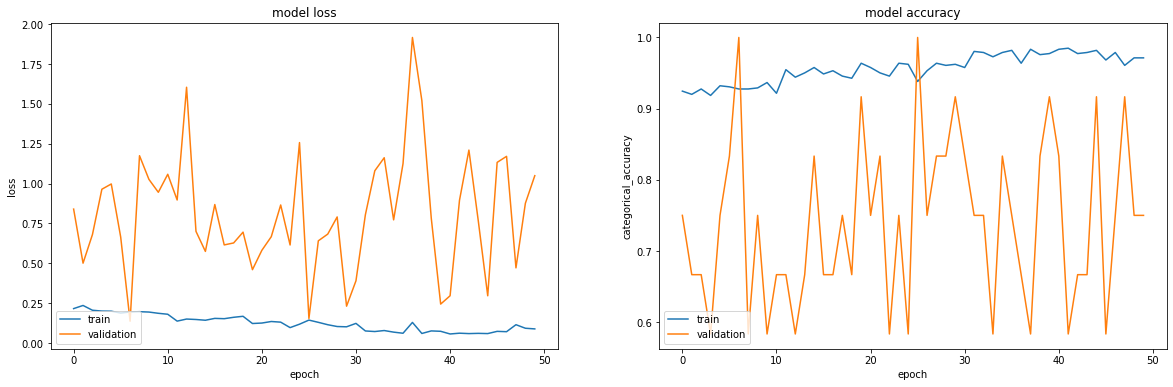

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')